In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.display import display

In [2]:
# Sourced from the UCI website
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
full_X = spambase.data.features 
full_y = spambase.data.targets 

# Split off test dataset while keeping the same ratio
full = full_X.join(full_y)
train, test = train_test_split(full, test_size=0.20, stratify=full['Class'], random_state=123)

y = pd.DataFrame(train.pop('Class')).reset_index(drop=True)
X = train.reset_index(drop=True)

In [11]:
def wrap_model(model, scaler=StandardScaler, transformers=[]):
    pipeline = make_pipeline(*transformers, scaler(), model)
    return pipeline

In [8]:
# Log transform capital columns
def capital_log_transform(X):
    X = X.copy()
    rest_cols = X.filter(like='capital').columns
    X[rest_cols] = np.log(X[rest_cols])
    return X
CapitalLogTransformer = FunctionTransformer(capital_log_transform)

# Convert percentages to [0,1] range
def freq_percent_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] /= 100
    return X
FreqPercentTransformer = FunctionTransformer(capital_log_transform)

# Sqrt transform freq cols
def freq_sqrt_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] = np.sqrt(X[freq_cols])
    return X
FreqSqrtTransformer = FunctionTransformer(freq_sqrt_transform)

# log transform freq cols
def freq_log_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] = np.log(X[freq_cols]+0.001)
    return X
FreqLogTransformer = FunctionTransformer(freq_log_transform)

# Mark zero freq values
def freq_zero_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    # Name them zero_i so later transform steps dont mess it up
    zero_mark_cols =  'zero_i' + pd.Index(np.arange(len(freq_cols))).astype(str)
    X[zero_mark_cols] = X[freq_cols] > 0
    return X
FreqZeroTransformer = FunctionTransformer(freq_zero_transform)

## PCA

[0.11816178]


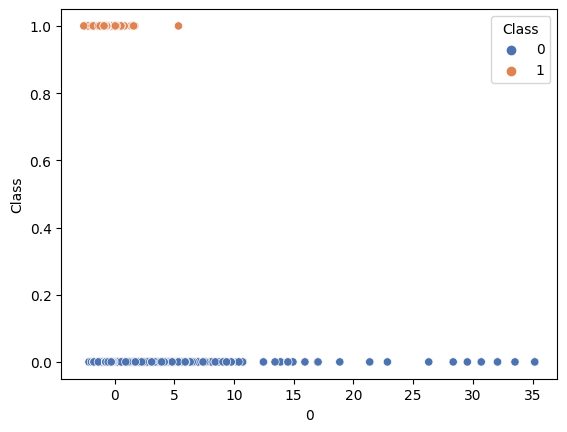

[0.11816178 0.05867519]


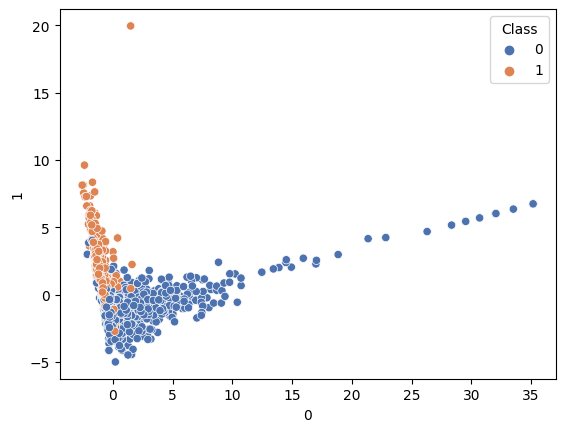

In [4]:
pca = wrap_model(PCA(n_components=1)).fit(X)
pca_out = pd.DataFrame(pca.transform(X))
sns.scatterplot(pca_out, x=0, y=y['Class'],hue=y['Class'], palette='deep')
print(pca[1].explained_variance_ratio_)
plt.show()
pca = wrap_model(PCA(n_components=2)).fit(X)
pca_out = pd.DataFrame(pca.transform(X))
sns.scatterplot(pca_out, x=0, y=1, hue=y['Class'], palette='deep')
print(pca[1].explained_variance_ratio_)
plt.show()

0.9985060045068274


array([0.92342645, 0.07507955])

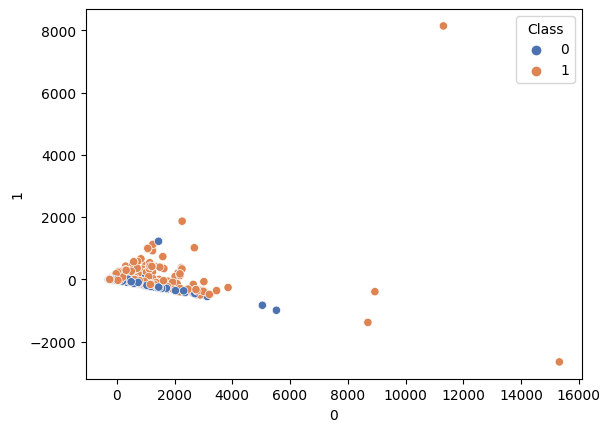

In [10]:
# Checking unscaled, the non-freq values dominate here.
pca = PCA(n_components=2).fit(X)
pca_out = pd.DataFrame(pca.transform(X))
sns.scatterplot(pca_out, x=0, y=1, hue=y['Class'], palette='deep')
print(sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

In [9]:
# Checking component values
pd.DataFrame(pca[1].components_, columns=X.columns).T.sort_values(by=0)

,0,1
word_freq_you,-0.079627,0.181055
word_freq_your,-0.074437,0.273986
char_freq_$,-0.055357,0.259238
word_freq_000,-0.051517,0.243938
word_freq_receive,-0.047216,0.216351
word_freq_over,-0.046014,0.179830
word_freq_remove,-0.045614,0.144901
word_freq_order,-0.045295,0.229668
word_freq_business,-0.044997,0.206039
word_freq_all,-0.043017,0.166037


### Filtering out outliers that werent spam in the original

<Axes: xlabel='0', ylabel='Class'>

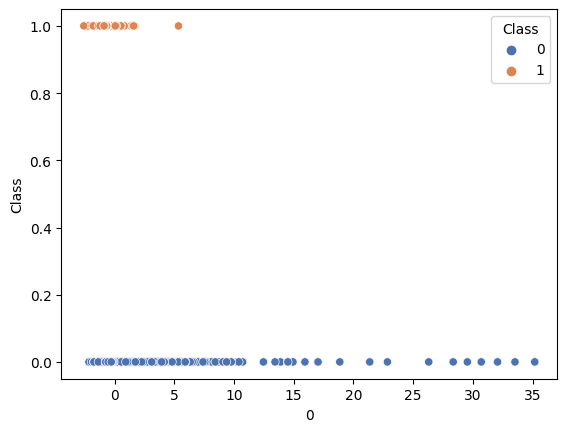

In [11]:
pca = wrap_model(PCA(n_components=1)).fit(X)
pca_out1 = pd.DataFrame(pca.transform(X))
sns.scatterplot(pca_out1, x=0, y=y['Class'],hue=y['Class'], palette='deep')


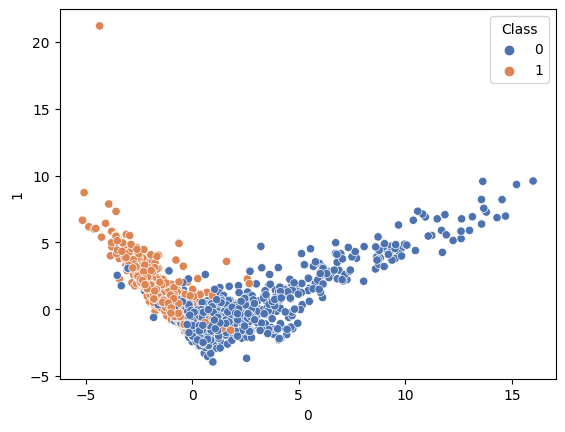

array([0.07752856, 0.05378233])

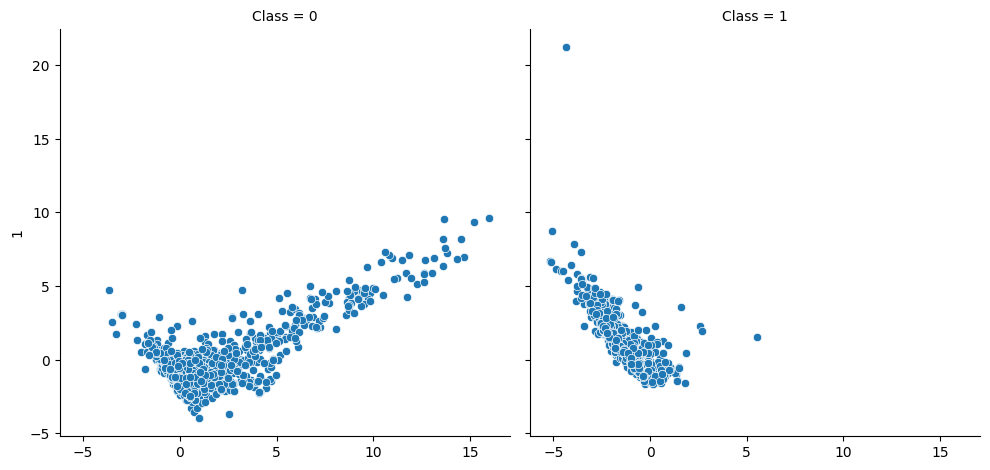

In [12]:
X_filtered = X[pca_out1[0] < 10].reset_index()
y_filtered = y[pca_out1[0] < 10].reset_index()
pca = wrap_model(PCA(n_components=2)).fit(X_filtered)
pca_out2 = pd.DataFrame(pca.transform(X_filtered))
sns.scatterplot(pca_out2, x=0, y=1,hue=y_filtered['Class'], palette='deep')
plt.show()

sns.relplot(pca_out2, x=0, y=1, col=y_filtered['Class'])
pca[1].explained_variance_ratio_
# Very bad ratios, but interesting separation

In [14]:
pd.DataFrame(pca[1].components_, columns=X_filtered.columns).T.sort_values(by=0)

,0,1
word_freq_your,-0.166471,0.228583
word_freq_you,-0.144040,0.133812
char_freq_$,-0.139966,0.224794
word_freq_000,-0.131003,0.213119
word_freq_receive,-0.115445,0.187216
word_freq_order,-0.112233,0.211116
word_freq_business,-0.111209,0.176357
word_freq_remove,-0.103357,0.105682
word_freq_over,-0.102504,0.154464
capital_run_length_total,-0.098391,0.212609


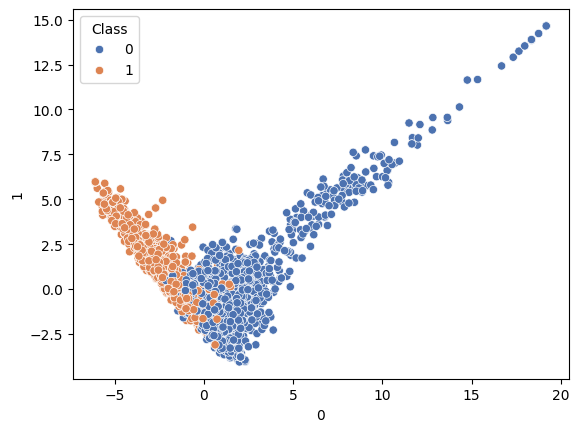

array([0.14059788, 0.10432872])

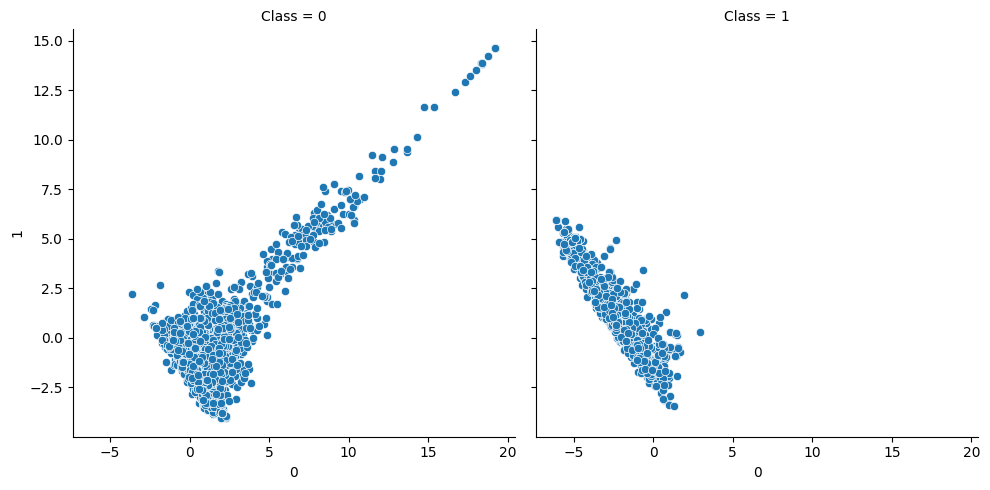

In [16]:
pca = wrap_model(PCA(n_components=2), transformers=[CapitalLogTransformer, FreqSqrtTransformer]).fit(X)
pca_out = pd.DataFrame(pca.transform(X))
sns.scatterplot(pca_out, x=0, y=1,hue=y['Class'], palette='deep')
plt.show()

sns.relplot(pca_out, x=0, y=1, col=y['Class'])
pca[-1].explained_variance_ratio_

## Transforming the data first

## PCA reduction

In [23]:
pca = wrap_model(PCA(n_components=0.99, whiten=True, svd_solver='full'))
pca_out = pca.fit_transform(X)
pca[1].components_.shape

(54, 57)

## Kernel PCA

Class
1        1188
0         427
Name: count, dtype: int64

Class
0        1803
1         262
Name: count, dtype: int64

0    0.117935
1    0.667286
dtype: float64

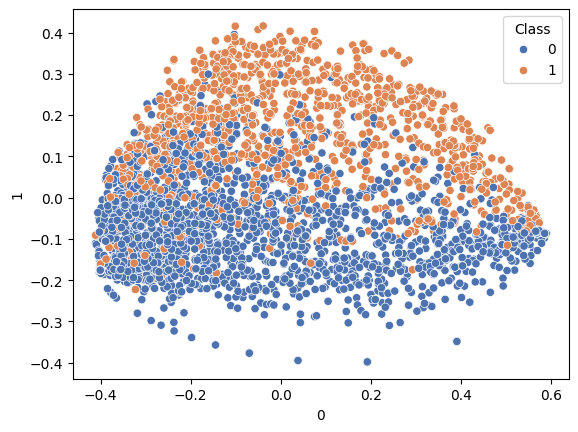

In [4]:
kpca = wrap_model(KernelPCA(kernel="rbf", n_components=2))
kpca_out = pd.DataFrame(kpca.fit_transform(X))
sns.scatterplot(kpca_out, x=0, y=1,hue=y['Class'], palette='deep')

display(y[kpca_out[1]>0].value_counts())
display(y[kpca_out[1]<0].value_counts())

kpca_out.corrwith(y['Class'])

# Component 1 has a high correlation with the class,
# But using it in practice doesnt help performance?

0   -0.381927
1    0.592628
dtype: float64

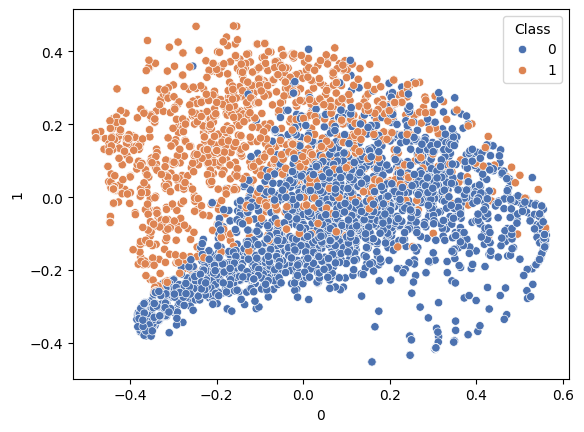

In [19]:
kpca = wrap_model(KernelPCA(kernel="rbf", n_components=2), transformers=[CapitalLogTransformer, FreqSqrtTransformer]).fit(X)
kpca_out = pd.DataFrame(kpca.fit_transform(X))
sns.scatterplot(kpca_out, x=0, y=1,hue=y['Class'], palette='deep')

kpca_out.corrwith(y['Class'])


## LDA

Class
1        1297
0         169
Name: count, dtype: int64

Class
0        2061
1         153
Name: count, dtype: int64

Class
0        2061
1        1449
Name: count, dtype: int64

array([1.])

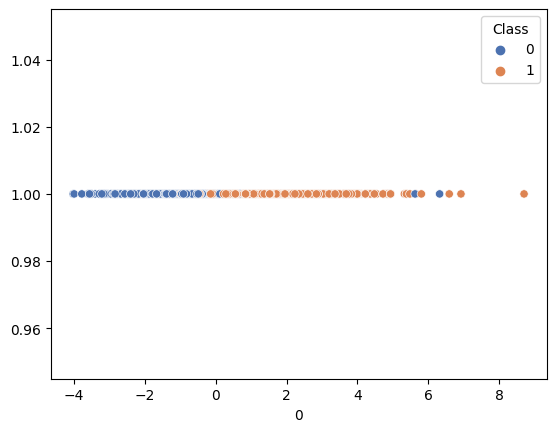

In [88]:
lda = wrap_model(LinearDiscriminantAnalysis(n_components=1))
lda_out = pd.DataFrame(lda.fit(X, y['Class']).transform(X))

sns.scatterplot(lda_out, x=0, y=1,hue=y['Class'], palette='deep')

display(y[lda_out[0]>=0].value_counts())
display(y[lda_out[0]<0].value_counts())

display(y[lda_out[0]>-2].value_counts())

lda[1].explained_variance_ratio_

## NMF

Class
1        984
0        334
Name: count, dtype: int64

Class
0        1896
1         466
Name: count, dtype: int64

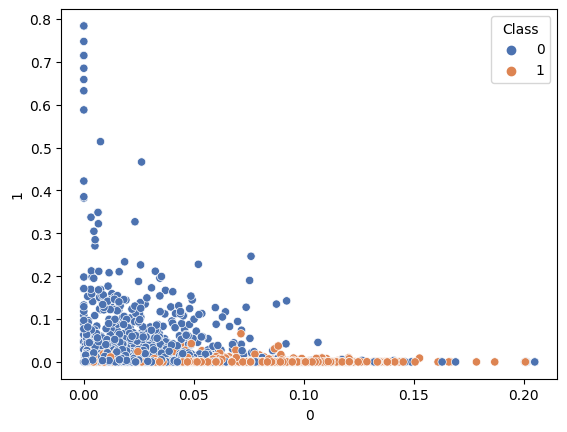

In [94]:
from sklearn.decomposition import NMF

nmf = wrap_model(NMF(n_components=2, random_state=42), scaler=MinMaxScaler)
nmf_out = pd.DataFrame(nmf.fit_transform(X))

sns.scatterplot(nmf_out[nmf_out[0]<15], x=0, y=1,hue=y['Class'], palette='deep')

display(y[nmf_out[0]>0.05].value_counts())
display(y[nmf_out[0]<0.05].value_counts())

## RFECV

In [101]:
from sklearn.feature_selection import RFECV

model = RandomForestClassifier(random_state=42)
X_scaled = StandardScaler().fit_transform(X)
rfecv = RFECV(
    estimator=model, 
    step=1, 
    scoring="accuracy", 
    n_jobs=-1,
    verbose=1
)
rfecv.fit(X_scaled, y['Class'])
rfecv.transform(X_scaled)

array([[-0.34333343, -0.16689868, -0.55920569, ..., -0.1143906 ,
        -0.14485983, -0.31380525],
       [-0.34333343, -0.16689868,  0.30818185, ..., -0.0763402 ,
        -0.15959053, -0.25034451],
       [-0.34333343, -0.16689868, -0.16493863, ..., -0.08274221,
        -0.20378261, -0.03880869],
       ...,
       [-0.10843212, -0.16689868, -0.42121222, ..., -0.06838289,
         0.04172896,  0.82360658],
       [ 0.76405844,  0.3431034 , -0.55920569, ..., -0.13359665,
        -0.22342354, -0.36750281],
       [-0.34333343, -0.16689868, -0.55920569, ..., -0.09757174,
        -0.19887238, -0.39191079]])

In [102]:
(rfecv.n_features_, X.shape[1])
# RFECV did not find any reduction without lowering accuracy...

(57, 57)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

In [ ]:
# Reducing Dim

In [22]:
freq_cols = X.filter(like='freq')
res = pd.DataFrame({
    'regular': freq_cols.corrwith(y['Class']),
    'sqrt': np.sqrt(freq_cols).corrwith(y['Class']),
    'log': np.log(freq_cols + 0.001).corrwith(y['Class']),
})
res.sort_values(by='sqrt')

,regular,sqrt,log
word_freq_hp,-0.250703,-0.358158,-0.402149
word_freq_hpl,-0.224858,-0.307710,-0.340722
word_freq_george,-0.184252,-0.269225,-0.346594
word_freq_1999,-0.180894,-0.240081,-0.264973
word_freq_labs,-0.170095,-0.220777,-0.242715
word_freq_85,-0.143131,-0.207089,-0.217896
word_freq_650,-0.164110,-0.206617,-0.222454
word_freq_edu,-0.142765,-0.197424,-0.203666
word_freq_lab,-0.129807,-0.194464,-0.222416
word_freq_telnet,-0.133579,-0.177708,-0.197188


In [63]:
low_corr_cols = res[(res['sqrt'] < 0) & (abs(res['sqrt'])<0.1)].index
low_corr_cols

Index(['word_freq_parts', 'word_freq_direct', 'word_freq_table', 'char_freq_;',
       'char_freq_('],
      dtype='object')

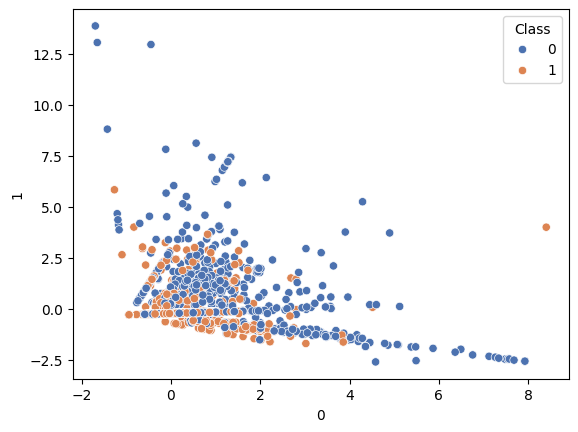

array([0.25833156, 0.20818697])

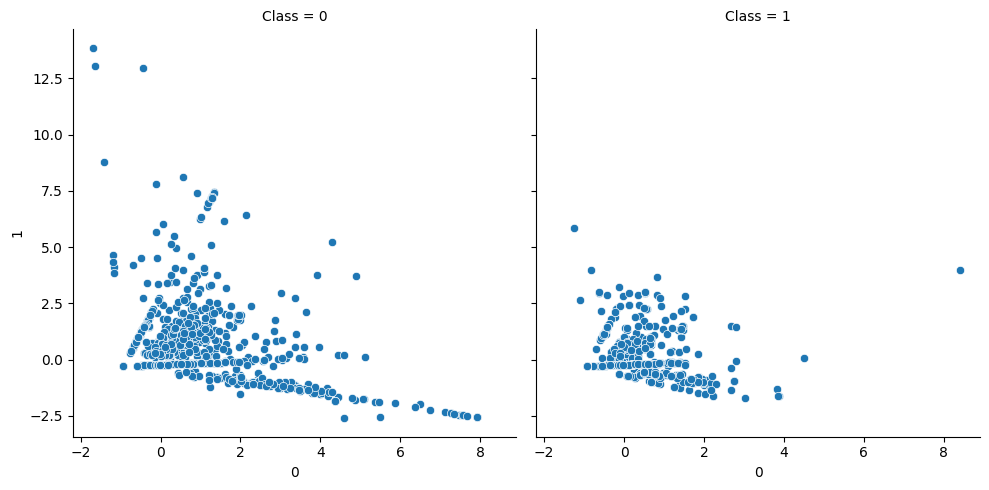

In [64]:
pca = wrap_model(PCA(n_components=2), transformers=[CapitalLogTransformer, FreqSqrtTransformer]).fit(X[low_corr_cols])
pca_out = pd.DataFrame(pca.transform(X[low_corr_cols]))
sns.scatterplot(pca_out, x=0, y=1,hue=y['Class'], palette='deep')
plt.show()

sns.relplot(pca_out, x=0, y=1, col=y['Class'])
pca[-1].explained_variance_ratio_

In [65]:
pca_out.corrwith(y['Class'])

0   -0.063675
1   -0.075749
dtype: float64

In [60]:
from sklearn.preprocessing import PolynomialFeatures
def wrap_model2(scaler=StandardScaler, transformers=[], poly=False):
    def inner(model):
        return make_pipeline(*transformers,
                             *([PolynomialFeatures(2, interaction_only=True)] if poly else []),
                             *([scaler()] if scaler else []),  
                             model)
    return inner

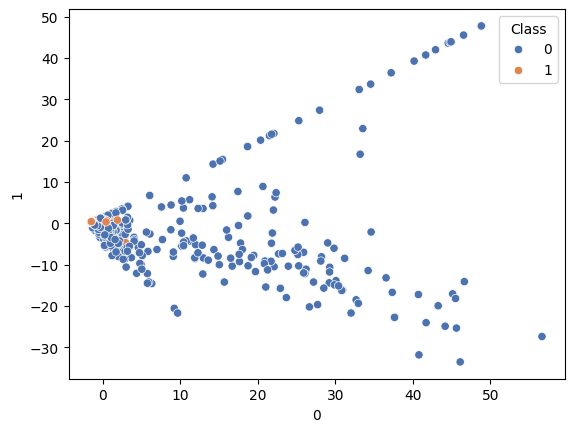

array([0.15173649, 0.07255769])

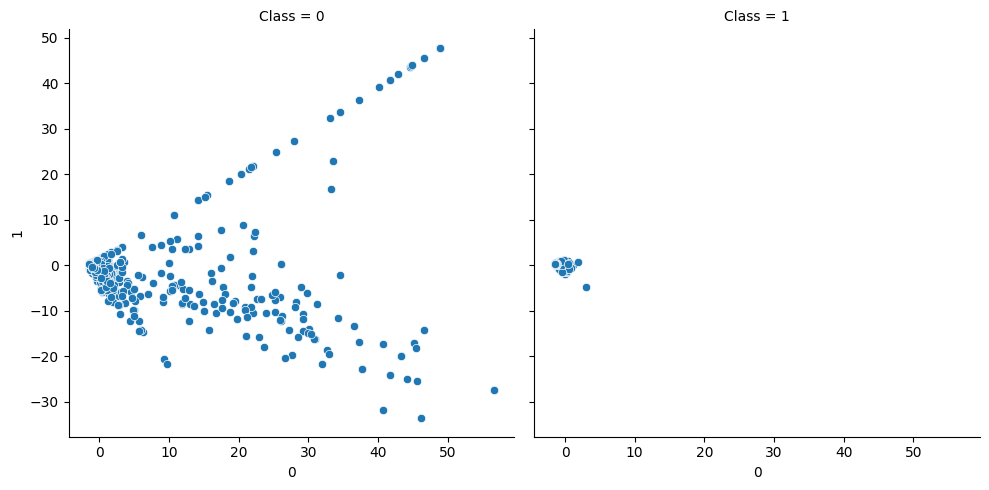

In [61]:
pca = wrap_model2(poly=True, transformers=[CapitalLogTransformer, FreqSqrtTransformer])(PCA(n_components=2)).fit(X[low_corr_cols])
pca_out = pd.DataFrame(pca.transform(X[low_corr_cols]))
sns.scatterplot(pca_out, x=0, y=1,hue=y['Class'], palette='deep')
plt.show()

sns.relplot(pca_out, x=0, y=1, col=y['Class'])
pca[-1].explained_variance_ratio_

In [62]:
pca_out.corrwith(y['Class'])

0   -0.176005
1    0.062057
dtype: float64